,CasosDia,Temp. Ins. (C),Umi. Ins. (%),Chuva (mm),CasosDiasTarget
Data,,,,,
2020-03-22,3,26.616667,42.500000,4.453936,4
2020-03-23,3,26.462500,52.833333,4.453936,2
2020-03-24,3,24.812500,64.541667,8.800000,2
2020-03-25,1,22.008333,82.000000,28.800000,2
2020-03-26,0,21.225000,83.666667,0.200000,3
...,...,...,...,...,...
2023-12-27,8,22.787500,80.750000,4.453936,3
2023-12-28,4,24.291667,70.416667,4.453936,6
2023-12-29,7,25.687500,69.083333,4.453936,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1380 entries, 2020-03-22 to 2023-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CasosDia         1380 non-null   int64  
 1   Temp. Ins. (C)   1380 non-null   float64
 2   Umi. Ins. (%)    1380 non-null   float64
 3   Chuva (mm)       1380 non-null   float64
 4   CasosDiasTarget  1380 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 64.7 KB


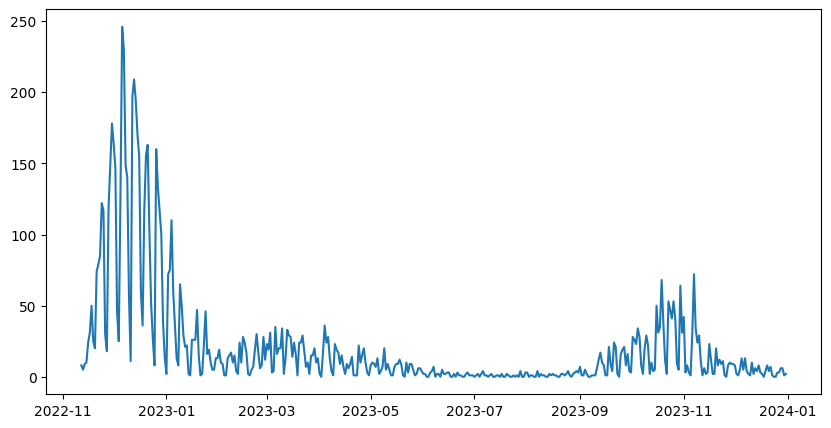

In [2]:
##IMPORTANDO

#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
from scipy.stats import mannwhitneyu
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Evitar avisos
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfDias7desloc.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

split = int(0.7 * len(df))
treino = df[:split]
teste = df[split:]


x_treino = treino.drop(columns='CasosDiasTarget')
y_treino = treino['CasosDiasTarget']

x_teste = teste.drop(columns='CasosDiasTarget')
y_teste = teste['CasosDiasTarget']

# Plotar as previsões em relação aos valores reais

plt.figure(figsize=(10, 5))
plt.plot(y_teste)



# XGBoost


In [3]:
#XG
from xgboost import XGBRegressor


mseXG = []
rmseXG= []
maeXG= []

p_XGbooster = []
p_XGestimators = []


param_grid = {'booster': ['gblinear', 'gbtree'], 'n_estimators':[100,200,500,1000]}

melhor_validacao_XG = 1000
best_paramsXG = {}



for i in range(20):
    print(i+1)
    for booster in param_grid['booster']:
        for estimators in param_grid['n_estimators']:
            XG = XGBRegressor(booster=booster, n_estimators=estimators)
            XG.fit(x_treino, y_treino)
            opiniao = XG.predict(x_teste)
            mse_validacao_XG = mean_squared_error(y_teste, opiniao)
            
            if (mse_validacao_XG < melhor_validacao_XG):
                melhor_validacao_XG = mse_validacao_XG
                best_paramsXG = {
                    'booster': booster,
                    'n_estimators':estimators
                }


    print(melhor_validacao_XG)
    print(mse_validacao_XG)
    print(best_paramsXG)


    XG = XGBRegressor(booster=best_paramsXG['booster'], n_estimators=best_paramsXG['n_estimators'])
    
    XG.fit(x_treino, y_treino)
    opiniao_XG = XG.predict(x_teste)

    mae = mean_absolute_error(y_teste, opiniao_XG).round(2)
    mse = mean_squared_error(y_teste, opiniao_XG).round(2)
    rmse = np.sqrt(mse).round(2)

    maeXG.append(mae)
    mseXG.append(mse)
    rmseXG.append(rmse)

    p_XGbooster.append(best_paramsXG['booster'])
    p_XGestimators.append(best_paramsXG['n_estimators'])

# RESULTADOS !!!!
maxp_XGbooster = max(set(p_XGbooster), key=p_XGbooster.count)
maxp_XGestimators = max(set(p_XGestimators), key=p_XGestimators.count)



media_maeXG = np.mean(maeXG)
media_mseXG = np.mean(mseXG)
media_rmseXG = np.mean(rmseXG)

p_XGbooster.append(maxp_XGbooster)
p_XGestimators.append(maxp_XGestimators)


maeXG.append(media_maeXG)
mseXG.append(media_mseXG)
rmseXG.append(media_rmseXG)

dfXG = pd.DataFrame({
    'booster':p_XGbooster,
    'estimators':p_XGestimators,
    'MAE': maeXG,
    'MSE': mseXG,
    'RMSE': rmseXG
})

print("O ÚLTIMO VALOR (20) É A MÉDIA !!!")

display(dfXG)
dfXG.to_csv('resultadosModelos/dfXG.csv', sep = ';', index = False, encoding='UTF-8')


1
408.1959876847231
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
2
404.6870587439142
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
3
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
4
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
5
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
6
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
7
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
8
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
9
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
10
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
11
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimators': 100}
12
401.24424890084754
900.0128229766544
{'booster': 'gblinear', 'n_estimator

,booster,estimators,MAE,MSE,RMSE
0,gblinear,100,13.340,402.9600,20.070
1,gblinear,100,13.640,408.9100,20.220
2,gblinear,100,13.580,407.4900,20.190
3,gblinear,100,13.460,405.2800,20.130
4,gblinear,100,13.300,402.1200,20.050
5,gblinear,100,13.650,409.1000,20.230
6,gblinear,100,13.490,405.6600,20.140
7,gblinear,100,13.670,409.6200,20.240
8,gblinear,100,13.590,407.7900,20.190
9,gblinear,100,13.560,406.9700,20.170


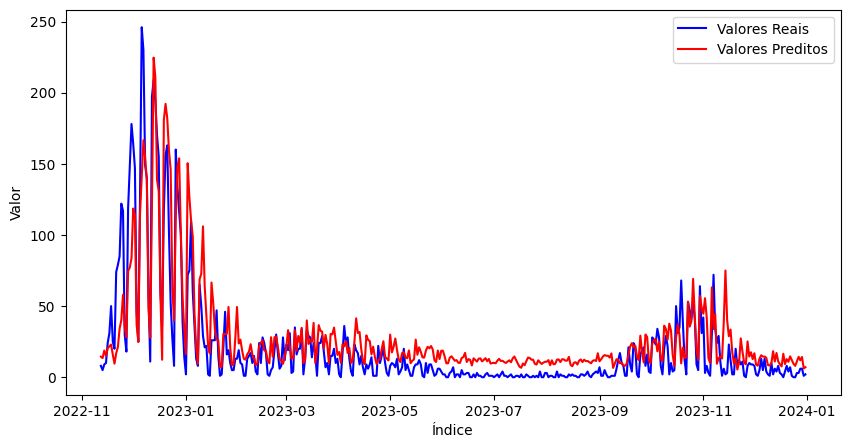

Numero de casos reais:  8737
Numero de casos predito:  11515


In [6]:
len(opiniao_XG)


serie_XG = pd.Series(opiniao_XG, index=x_teste.index)


plt.figure(figsize=(10, 5))
plt.plot(y_teste, label='Valores Reais', color='blue')
plt.plot(serie_XG, label='Valores Preditos', color='red')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.savefig('graficos/4-xgboost.pdf', dpi=300, bbox_inches = "tight")
plt.legend()

plt.show()


n_pred = int(serie_XG.sum())
print('Numero de casos reais: ', y_teste.sum())
print('Numero de casos predito: ', n_pred)
